## 1. Exploratory Data Analysis

Total training samples: 891
Total test samples: 418


<Figure size 432x288 with 0 Axes>

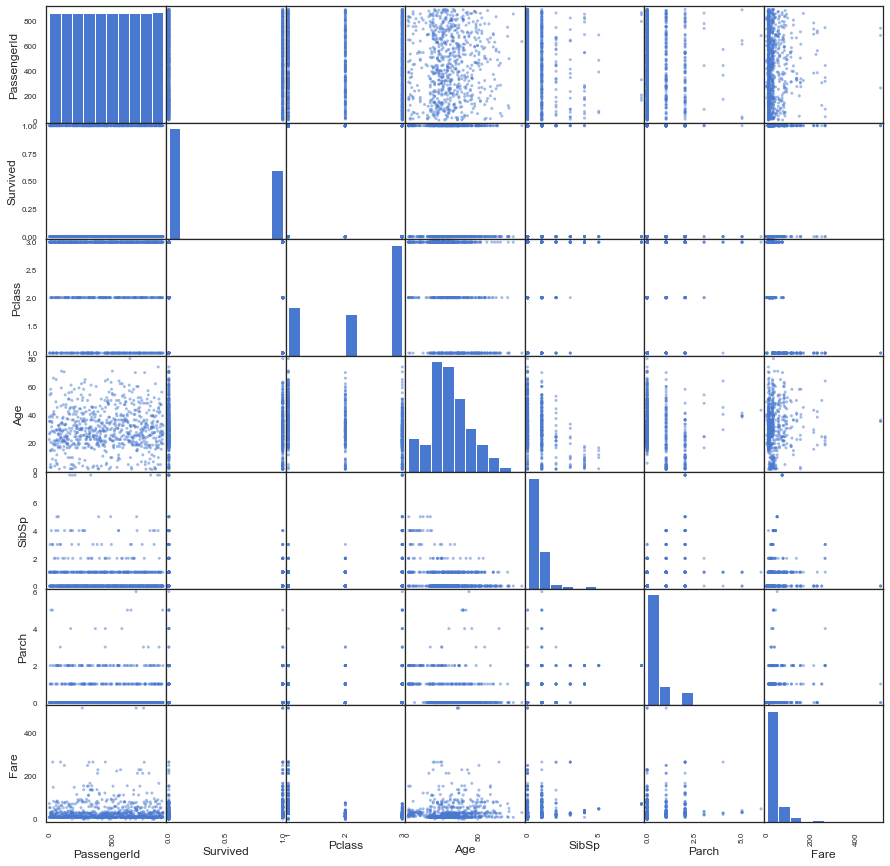

<Figure size 432x288 with 0 Axes>

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

# load data 
data_train = pd.read_csv('C:/Users/M1047692/Documents/Mindtree/NanoDegree/titanic/train.csv')
data_test = pd.read_csv('C:/Users/M1047692/Documents/Mindtree/NanoDegree/titanic/test.csv')
print("Total training samples: {n}".format(n=len(data_train)))
print("Total test samples: {n}".format(n=len(data_test)))

# helper funcs
sns.set(style="white", palette="muted", color_codes=True)
def is_nan(num):
    return num != num

# This pair plot gives visibility of the features that would Support survival rate.
pd.plotting.scatter_matrix(data_train,figsize=(15,15))
plt.figure()





## Data Dictionary 
***************
PassengerId		: Unique Id of a passenger
survival		: Whether a passenger survived or not; 1 if survived and 0 if not. 
pclass			: Ticket class
sex				: Sex
Age				: Age in years
sibsp			: Number of siblings / spouses aboard the Titanic
parch			: Number of parents / children aboard the Titanic
ticket			: Ticket number
fare			: Passenger fare
cabin			: Cabin number
embarked		: Port of Embarkation


## 2. Feature Engineering (Transformation)

In [3]:
import re

# preprocess data
_name_tokens = ['mr', 'ms', 'miss', 'dr', 'mrs']

def sanity_checks(df, is_train):
    assert (not is_train) or all(x in [0, 1] for x in df.Survived)
    assert all(x in [1,2,3] for x in df.Pclass)    
    assert all(not is_nan(x) for x in df.SibSp)
    assert all(not is_nan(x) for x in df.Parch)
    assert all(x in ["S", "C", "U", "Q"] for x in df.Embarked)

def extract_token_from_name(name):
    for ch in "(),.\'\"":
        name = name.replace(ch, " ")
    tokens = name.split()
    name = "unknown"
    for token in tokens:
        if token.lower() in _name_tokens: 
            name = token.lower()
    return name

def preprocess_name(df):    
    df.Name = df.Name.apply(lambda x: extract_token_from_name(x))
    return df

def preprocess_sex(df):
    df.Sex = df.Sex.apply(lambda x: x.lower() if x.lower() in ["female", "male"] else "unknown")
    return df

def preprocess_age(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df
  
def preprocess_fare(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 50, 100, 300, 1000)
    group_names = ['Unknown', 'fare_1', 'fare_2', 'fare_3', 'fare_4', 'fare_5', 'fare_6', 'fare_7']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def cabin_to_range(cabin):    
    if is_nan(cabin):
        return 'X'
    r = re.match(r"(\w+ )*([A-Z])(\d+)", cabin)
    if r:
        return "%s%d" % (r.groups()[-2], int(r.groups()[-1]) / 4)
    else:
        return 'X'

def cabin_to_oddness(cabin):    
    if is_nan(cabin):
        return 'X'
    r = re.match(r"(\w+ )*([A-Z])(\d+)", cabin)
    if r:
        return "%s%d" % (r.groups()[-2], int(r.groups()[-1]) % 2)
    else:
        return 'X'

def preprocess_cabin(df):
    df['Cabin_range'] = df["Cabin"].apply(lambda x: cabin_to_range(x))
    df['Cabin_oddness'] = df["Cabin"].apply(lambda x: cabin_to_oddness(x))
    df = df.drop(['Cabin'], axis=1)
    return df

def drop_features(df):
    return df.drop(['Ticket'], axis=1)

def preprocess_embarked(df):
    df.Embarked = df.Embarked.fillna('U')
    return df

# run this func for both train and test
def preprocess(df, is_train):    
    df = preprocess_embarked(df)
    df = preprocess_sex(df)
    df = preprocess_age(df)
    df = preprocess_fare(df)
    df = preprocess_cabin(df)
    df = preprocess_name(df)
    df = drop_features(df)
    sanity_checks(df, is_train)
    return df


data_train = preprocess(data_train.copy(), is_train=True)
data_test = preprocess(data_test.copy(), is_train=False)
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_range,Cabin_oddness
0,1,0,3,mr,male,Student,1,0,fare_1,S,X,X
1,2,1,1,mrs,female,Adult,1,0,fare_5,C,C21,C1
2,3,1,3,miss,female,Young Adult,0,0,fare_1,S,X,X
3,4,1,1,mrs,female,Young Adult,1,0,fare_5,S,C30,C1
4,5,0,3,mr,male,Young Adult,0,0,fare_2,S,X,X


## 3. Feature Selection and Extraction.

In [4]:
# encode features
_features = ["Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin_range", "Cabin_oddness", "Embarked"]

def encode_features(train_df, test_df, features):    
    combined = pd.concat([train_df[features], test_df[features]])
    
    encoders = list()
    for feature in features:
        le = preprocessing.LabelEncoder()
        le.fit(combined[feature])
        train_df[feature] = le.transform(train_df[feature])
        test_df[feature] = le.transform(test_df[feature])
        encoders.append(le)
    train_df = train_df.sort_values("PassengerId")
    test_df = test_df[['PassengerId'] + features].sort_values('PassengerId')
    assert(len(encoders) == len(features))
    return train_df, test_df, encoders
       
data_train, data_test, _ = encode_features(data_train, data_test, features=_features)
print("First 5 data_train out of {n}".format(n=len(data_train.values)))
print(data_train.head(5))
print("First 5 data_test out of {n}".format(n=len(data_test.values)))
print(data_test.head(5))

First 5 data_train out of 891
   PassengerId  Survived  Pclass  Name  Sex  Age  SibSp  Parch  Fare  \
0            1         0       2     2    1    4      1      0     1   
1            2         1       0     3    0    0      1      0     5   
2            3         1       2     1    0    7      0      0     1   
3            4         1       0     3    0    7      1      0     5   
4            5         0       2     2    1    7      0      0     2   

   Embarked  Cabin_range  Cabin_oddness  
0         2           98             14  
1         0           43              5  
2         2           98             14  
3         2           51              5  
4         2           98             14  
First 5 data_test out of 418
   PassengerId  Pclass  Name  Sex  Age  SibSp  Parch  Fare  Cabin_range  \
0          892       2     2    1    7      0      0     1           98   
1          893       2     3    0    0      1      0     1           98   
2          894       1     2   

## Dimensionality Reduction

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [6]:
scaled_data = scaler.transform(data_train)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
x_pca = pca.transform(scaled_data)
x_pca.shape

(891, 2)

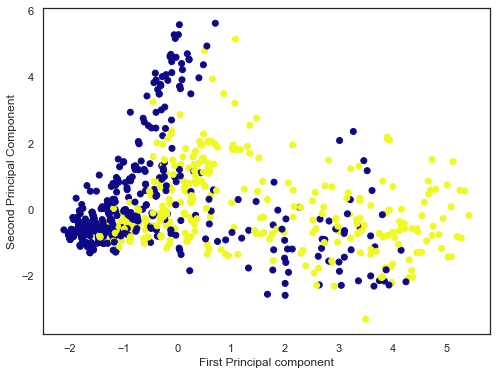

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=data_train['Survived'], cmap='plasma')

plt.xlabel('First Principal component')
plt.ylabel('Second Principal Component')
display()

## 4. Cross Validation - K Fold/ Train test split

In [22]:
from sklearn.model_selection import KFold

def split_data_train(data_train, features, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=13)

    # training features
    X = data_train[features]
    
    # training labels
    y = data_train['Survived']
    
    print("Split train data into %d folds" % kf.get_n_splits(X))
    
    print("First 3 X_train out of {n}".format(n=len(X.values)))
    print(X.head(3))
    print("First 3 y_train out of {n}".format(n=len(y.values)))
    print(y.head(3))
    
    return X, y, kf

X, y, kf = split_data_train(data_train=data_train, features=_features)

Split train data into 5 folds
First 3 X_train out of 891
   Pclass  Name  Sex  Age  SibSp  Parch  Fare  Cabin_range  Cabin_oddness  \
0       2     2    1    4      1      0     1           98             14   
1       0     3    0    0      1      0     5           43              5   
2       2     1    0    7      0      0     1           98             14   

   Embarked  
0         2  
1         0  
2         2  
First 3 y_train out of 891
0    0
1    1
2    1
Name: Survived, dtype: int64


## 5. Training the Base Models

In [23]:
from time import time
from sklearn.metrics import make_scorer, accuracy_score

BASE_MODELS = ['LogReg', 'Perceptron', 'KNN', 'SVC', 'LinearSVC', 'DecisionTree', 'RandomForest', 'XGBoost']
NUM_OF_BASE_MODELS = len(BASE_MODELS)
model_accuracy = dict.fromkeys(BASE_MODELS)

X_stack_train = pd.DataFrame(np.zeros((X.shape[0], NUM_OF_BASE_MODELS),
                                      dtype=np.float64),
                             columns=BASE_MODELS)
y_stack_train = y  # ground truth
X_stack_test = pd.DataFrame(np.zeros((data_test.shape[0], NUM_OF_BASE_MODELS),
                                     dtype=np.float64),
                            columns=BASE_MODELS)

def _get_accuracy(y_fold, y_predict):
    """helper function"""
    # y_predict may be a proba. convert it to 0/1
    y_tmp = np.copy(y_predict)
    for i in range(len(y_tmp)):
        y_tmp[i] = 1 if y_tmp[i] >= 0.5 else 0
    return accuracy_score(y_fold, y_tmp)    
    

def train_base_model_and_predict(estimator, X, y, model_name, kf, X_test, predictor='predict_proba'):
    """
    Input
    X: full train data
    y: full train label
    model_name: each base model has a unique name
    kf: KFolder spliter
    X_test: test data
    predictor: 'predict' or 'predict_proba'
    Output
    X_stack_train
    
    """
    model_idx = BASE_MODELS.index(model_name)
    print("Trainging Base Model #%d:" % model_idx)
    print(estimator)
    start = time()    
    # this stores n_folds this many predicts of test data. 
    n_folds = kf.get_n_splits(X)
    y_predict_of_model = np.zeros((data_test.shape[0], n_folds))
    # we call the prediction fold of training data as "stack_train"
    i = 0
    mean_accuracy = 0.0
    for train_index, stack_train_index in kf.split(X):
        # train model on X_train (4 folds)
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]        
        estimator.fit(X_train, y_train)
        
        # predict on the single fold
        X_fold = X.iloc[stack_train_index]
        y_fold = y.iloc[stack_train_index]
        y_stack_train_predict = estimator.predict_proba(X_fold)[:, 1] if predictor == 'predict_proba' else estimator.predict(X_fold)
        X_stack_train.iloc[stack_train_index, model_idx] = y_stack_train_predict 
        accuracy = _get_accuracy(y_fold=y_fold, y_predict=y_stack_train_predict)
        print("Accuracy = {s} on fold {i}".format(s=accuracy, i=i))
        mean_accuracy += accuracy
        
        # also predict on X_test
        y_predict_of_model[:, i] = estimator.predict_proba(X_test)[:, 1] if predictor == 'predict_proba' else estimator.predict(X_test)
        i += 1
    # finally average y_predict of test 
    X_stack_test.iloc[:, model_idx] = y_predict_of_model.mean(1)        
    print("Training took %.2f seconds" % (time() - start))
    model_accuracy[model_name] = mean_accuracy / i
    print("Mean accuracy = %.4f" % model_accuracy[model_name])

## 6. Model Building with Multiple Algo's

In [24]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2', C=1.0)
train_base_model_and_predict(estimator=logreg, X=X, y=y, model_name='LogReg', kf=kf, 
                             X_test=data_test[_features], predictor='predict_proba')

Trainging Base Model #0:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy = 0.7988826815642458 on fold 0
Accuracy = 0.7808988764044944 on fold 1
Accuracy = 0.7752808988764045 on fold 2
Accuracy = 0.797752808988764 on fold 3
Accuracy = 0.8146067415730337 on fold 4
Training took 0.05 seconds
Mean accuracy = 0.7935


C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-package

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=1)
train_base_model_and_predict(estimator=knn, X=X, y=y, model_name='KNN', kf=kf,
                             X_test=data_test[_features], predictor='predict_proba')

Trainging Base Model #2:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')
Accuracy = 0.7988826815642458 on fold 0
Accuracy = 0.7808988764044944 on fold 1
Accuracy = 0.7752808988764045 on fold 2
Accuracy = 0.7752808988764045 on fold 3
Accuracy = 0.8146067415730337 on fold 4
Training took 0.07 seconds
Mean accuracy = 0.7890


In [26]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', C=4.6415888336127775)
train_base_model_and_predict(estimator=svc, X=X, y=y, model_name='SVC', kf=kf,
                             X_test=data_test[_features], predictor='predict')

Trainging Base Model #3:
SVC(C=4.6415888336127775, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Accuracy = 0.8268156424581006 on fold 0
Accuracy = 0.7808988764044944 on fold 1
Accuracy = 0.7584269662921348 on fold 2
Accuracy = 0.7696629213483146 on fold 3
Accuracy = 0.7921348314606742 on fold 4
Training took 0.15 seconds
Mean accuracy = 0.7856


C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning

In [27]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.21544346900318834, penalty='l1', dual=False)
train_base_model_and_predict(estimator=lsvc, X=X, y=y, model_name='LinearSVC', kf=kf,
                             X_test=data_test[_features], predictor='predict')

Trainging Base Model #4:
LinearSVC(C=0.21544346900318834, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l1', random_state=None,
          tol=0.0001, verbose=0)
Accuracy = 0.8100558659217877 on fold 0
Accuracy = 0.7865168539325843 on fold 1
Accuracy = 0.7752808988764045 on fold 2
Accuracy = 0.8033707865168539 on fold 3
Accuracy = 0.8370786516853933 on fold 4
Training took 0.12 seconds
Mean accuracy = 0.8025


C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklear

In [28]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_features='sqrt')
train_base_model_and_predict(estimator=tree, X=X, y=y, model_name='DecisionTree', kf=kf,
                             X_test=data_test[_features], predictor='predict_proba')

Trainging Base Model #5:
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Accuracy = 0.8100558659217877 on fold 0
Accuracy = 0.7640449438202247 on fold 1
Accuracy = 0.7528089887640449 on fold 2
Accuracy = 0.797752808988764 on fold 3
Accuracy = 0.8314606741573034 on fold 4
Training took 0.04 seconds
Mean accuracy = 0.7912


In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=11, criterion='entropy', max_features=None)
train_base_model_and_predict(estimator=rf, X=X, y=y, model_name='RandomForest', kf=kf,
                             X_test=data_test[_features], predictor='predict_proba')

Trainging Base Model #6:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=11,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy = 0.8491620111731844 on fold 0
Accuracy = 0.7865168539325843 on fold 1
Accuracy = 0.8033707865168539 on fold 2
Accuracy = 0.8202247191011236 on fold 3
Accuracy = 0.8764044943820225 on fold 4
Training took 0.14 seconds
Mean accuracy = 0.8271


In [30]:
xgb = XGBClassifier(max_depth=5, learning_rate=0.48329302385717521, n_estimators=15, gamma=0.8858)
train_base_model_and_predict(estimator=xgb, X=X, y=y, model_name='XGBoost', kf=kf,
                             X_test=data_test[_features], predictor='predict')

Trainging Base Model #7:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.8858,
              learning_rate=0.4832930238571752, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=15, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy = 0.8379888268156425 on fold 0
Accuracy = 0.8033707865168539 on fold 1
Accuracy = 0.8146067415730337 on fold 2
Accuracy = 0.8033707865168539 on fold 3
Accuracy = 0.8539325842696629 on fold 4
Training took 0.10 seconds
Mean accuracy = 0.8227


## 7.  Model Accuracy Scores and Correlation matrix.

== Model Accuracy ==
LogReg 0.7934844014813884
Perceptron None
KNN 0.7889900194589166
SVC 0.7855878475927437
LinearSVC 0.8024606113866047
DecisionTree 0.7912246563304249
RandomForest 0.8271357730211537
XGBoost 0.8226539451384094

== Model Correlations ==
                LogReg  Perceptron       KNN       SVC  LinearSVC  \
LogReg        1.000000         NaN  0.738268  0.701286   0.896744   
Perceptron         NaN         NaN       NaN       NaN        NaN   
KNN           0.738268         NaN  1.000000  0.792929   0.647498   
SVC           0.701286         NaN  0.792929  1.000000   0.661195   
LinearSVC     0.896744         NaN  0.647498  0.661195   1.000000   
DecisionTree  0.696125         NaN  0.686983  0.616702   0.618939   
RandomForest  0.804963         NaN  0.804066  0.729285   0.738781   
XGBoost       0.780557         NaN  0.771937  0.724197   0.724211   

              DecisionTree  RandomForest   XGBoost  
LogReg            0.696125      0.804963  0.780557  
Perceptron       

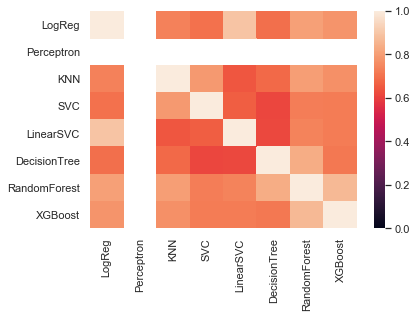

In [31]:
import operator
print("== Model Accuracy ==")
for m in model_accuracy:
    print(m, model_accuracy[m])
print("\n== Model Correlations ==")
print(X_stack_train.corr())
_ = sns.heatmap(X_stack_train.corr(), vmin=0, vmax=1)

## 8.  HyperParameter tuning.

In [32]:
# level 2 model selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def get_best_estimator(estimator, param, X_train, y_train, verbose=0, n_jobs=1, cv=5):
    """Run grid search to get the best hyper-parameter set for the given estimator.
    param is the map of various of hyper-parameters.
    cv is an int to specify the number of folds for training.
    """
    # Type of scoring used to compare parameter combinations
    acc_scorer = make_scorer(accuracy_score)

    grid_search = GridSearchCV(
        estimator=estimator, 
        param_grid=param,
        scoring=acc_scorer,
        verbose=verbose,
        cv=cv)

    start = time()
    grid_search.fit(X_train, y_train)
    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
          % (time() - start, len(grid_search.cv_results_['params'])))

    # get the best hyper-param set and its score
    return grid_search.best_estimator_, grid_search.best_score_

def try_each_stacking_model_combo(candidates):
    # Try each base model combination
    stack_performance = dict.fromkeys(candidates)
    cnt = 1
    for c in candidates:
        print("\nTrying combination #%d: %s" % (cnt, c))
        cnt += 1
        X_stack_train_tmp = X_stack_train[list(c)]
        X_stack_test_tmp = X_stack_test[list(c)]

        # specify the ranges of hyper-parameters
        logreg_param = {
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-3, 4, 8),
        }
        logreg_stacking, logreg_stacking_accu = get_best_estimator(
            estimator=LogisticRegression(), param=logreg_param, X_train=X_stack_train_tmp, y_train=y_stack_train)
        print("GridSearchCV found the best hyper-parameter set for LogReg_stacking:\n{s}\n\n{r}".format(
            s=logreg_stacking_accu, r=logreg_stacking.get_params()))
        stack_performance[c] = logreg_stacking_accu
    print("\nThe final best combinations:")
    print(sorted(stack_performance.iteritems(), key=operator.itemgetter(1), reverse=True)[:5])
    
from itertools import combinations
STACKING_MODELS = list(combinations(BASE_MODELS, r=2)) + list(combinations(BASE_MODELS, r=3)) + list(combinations(BASE_MODELS, r=4)) 
print("Tring total %d combinations" % len(list(STACKING_MODELS)))
# Note: uncomment this if you want to re-run the tuning.
#try_each_stacking_model_combo(candidates=STACKING_MODELS)

# The final best combinations:
#[(('SVC', 'LinearSVC', 'RandomForest', 'XGBoost'), 0.83052749719416386), 
#(('LogReg', 'LinearSVC', 'DecisionTree', 'RandomForest'), 0.82940516273849607), 
#(('LogReg', 'LinearSVC', 'RandomForest', 'XGBoost'), 0.82940516273849607), 
#(('LogReg', 'SVC', 'LinearSVC', 'RandomForest'), 0.82940516273849607), 
#(('LogReg', 'KNN', 'LinearSVC', 'RandomForest'), 0.82940516273849607)]

Tring total 154 combinations


## 9 . Model Stacking.

   SVC  LinearSVC  RandomForest  XGBoost
0  0.0        0.0      0.727273      0.0
1  0.0        1.0      1.000000      1.0
2  1.0        1.0      0.584091      1.0
3  0.0        1.0      1.000000      1.0
4  0.0        0.0      0.181333      0.0
   SVC  LinearSVC  RandomForest  XGBoost
0  0.0        0.0      0.282501      0.0
1  0.2        1.0      0.227965      0.0
2  0.0        0.0      0.167316      0.0
3  0.0        0.0      0.164386      0.0
4  1.0        1.0      0.418182      0.4

== Model Correlations ==
                   SVC  LinearSVC  RandomForest   XGBoost
SVC           1.000000   0.661195      0.729285  0.724197
LinearSVC     0.661195   1.000000      0.738781  0.724211
RandomForest  0.729285   0.738781      1.000000  0.867662
XGBoost       0.724197   0.724211      0.867662  1.000000


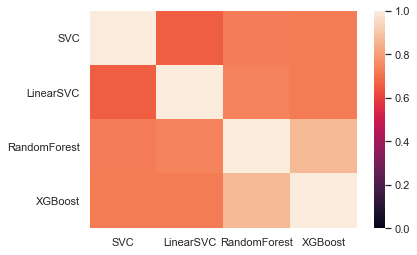

In [33]:
FINAL_BASE_MODELS = ["SVC", "LinearSVC", "RandomForest", "XGBoost"]
X_stack_train = X_stack_train[FINAL_BASE_MODELS]
X_stack_test = X_stack_test[FINAL_BASE_MODELS]
print(X_stack_train.head(5))
print(X_stack_test.head(5))
print("\n== Model Correlations ==")
print(X_stack_train.corr())
_ = sns.heatmap(X_stack_train.corr(), vmin=0, vmax=1)

In [34]:
def run_best_stacking_model(final_stacking_models):
    print("Trying ", final_stacking_models)
    X_stack_train_tmp = X_stack_train[final_stacking_models]
    X_stack_test_tmp = X_stack_test[final_stacking_models]

    # specify the ranges of hyper-parameters
    logreg_param = {
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-3, 4, 8),
    }
    logreg_stacking, logreg_stacking_accu = get_best_estimator(
        estimator=LogisticRegression(), param=logreg_param, X_train=X_stack_train_tmp, y_train=y_stack_train)
    print("GridSearchCV found the best hyper-parameter set for LogReg_stacking:\n{s}\n\n{r}".format(
        s=logreg_stacking_accu, r=logreg_stacking.get_params()))
    
    # now we've found the best hyper-param using CV, re-train the level 2 model on all stack_train data
    logreg_stacking.fit(X_stack_train_tmp, y_stack_train)
    # predict the test data
    y_submit_predict = logreg_stacking.predict(X_stack_test_tmp)
    submission = pd.DataFrame({
            "PassengerId": data_test["PassengerId"],
            "Survived": y_submit_predict
        })
    submission.to_csv('C:/Users/M1047692/Documents/Mindtree/NanoDegree/titanic/stack-submission.csv', index=False)
    submission.head(10)

run_best_stacking_model(FINAL_BASE_MODELS)

Trying  ['SVC', 'LinearSVC', 'RandomForest', 'XGBoost']


C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-package

C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-package

GridSearchCV took 0.39 seconds for 16 candidate parameter settings.
GridSearchCV found the best hyper-parameter set for LogReg_stacking:
0.835016835016835

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'warn', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\M1047692\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Finally the Model Stacking improved the overall accuracy better than any individual base model:

|Name|Accuracy|
|---|---|
| SVC  | 0.7856  |
| LinearSVC  | 0.8025  | 
|RandomForest| 0.8182  | 
|  XGBoost | 0.8227  | 
| Model-Stacking  | 0.8316  | 